In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from networkx.algorithms import bipartite

## FASE 1: COSTRUZIONE
* creare un grafo bipartito dalla edge list in ```./data/crime/out.moreno_crime_crime```
    __ATTENZIONE!!__ bisogna dividere i nodi people dai nodi crime perchè l'edge (1,1) non è un self loop ma indica che il primo nodo persona è legato al primo nodo crime, serve un mapping dei nodi!
* aggiungere ai nodi l'attributo 'name' dal file ```./data/crime/ent.moreno_crime_crime.person.name```
 aggiungere agli archi l'attributo 'crime-role' dal file ```./data/crime/rel.moreno_crime_crime.person.role```
* fare una proiezione sul piano delle persone: esiste un link tra due persone sse sono stati coinvolti in almeno un caso insieme. Mettere come peso il numero di crimini in comune. (potrebbe esistere una soluzione facile da nx)
<br>


In [2]:
edges = list(open('./crime/out.moreno_crime_crime','r'))
edges[:10]

['% bip unweighted\n',
 '% 1476 829 551\n',
 '1 1 \n',
 '1 2 \n',
 '1 3 \n',
 '1 4 \n',
 '2 5 \n',
 '2 6 \n',
 '2 7 \n',
 '2 8 \n']

In [3]:
edges_plus = []
for line in edges[2:]:
    lineplus = line.strip().split()
    edges_plus.append((int(lineplus[0]), int(lineplus[1])))
#[[int(x) for x in line.strip().split()] for line in edges[2:]]

In [5]:
people = set()
for x in edges_plus:
    people.add(x[0])
#set([x[0] for x in edges])
crimes = set([x[1] for x in edges_plus])

In [6]:
print(len(people), min(people), max(people))
print(len(crimes),min(crimes), max(crimes))

829 1 829
551 1 551


In [6]:
mapped_crimes = [x+829 for x in crimes]
mapped_edges = []
for person,crime in edges_plus:
    edge = (person, crime+829)
    mapped_edges.append(edge)
#[(person, crime+829) for person,crime in edges]

In [7]:
len(mapped_edges)

1476

In [8]:
B = nx.Graph()

B.add_nodes_from(people, bipartite=0)

B.add_nodes_from(mapped_crimes, bipartite=1)

B.add_edges_from(mapped_edges)



In [9]:
print(B)

Graph with 1380 nodes and 1476 edges


In [10]:
name = list(open('./crime/ent.moreno_crime_crime.person.name','r'))


In [11]:
len(name)

829

In [12]:
name_dictionary = {}
for i,line in enumerate(name):
    name_dictionary[i+1] = line.strip() 
    
#{i+1:line.strip() for i,line in enumerate(name)}

In [13]:
nx.set_node_attributes(B, name_dictionary,'name')

In [14]:
role = list(open('./crime/rel.moreno_crime_crime.person.role','r'))

In [15]:
role[:10]

['Suspect\n',
 'Victim\n',
 'Victim\n',
 'Suspect\n',
 'Victim\n',
 'Suspect\n',
 'Victim\n',
 'Suspect\n',
 'Suspect\n',
 'Suspect\n']

In [16]:
role_dictionary = {}
for i,line in enumerate(role):
    role_dictionary[mapped_edges[i]] = line.strip()
#{mapped_edges[i]:line.strip() for i,line in enumerate(role)}

In [17]:
nx.set_edge_attributes(B, role_dictionary,'crime-role')


## FASE 2: ANALISI BIPARTITO
* Quante persone includono i crimini in media?
* In quanti crimini sono incluse le persone in media?
* In quanti crimini sono incluse le persone in media essendo witness?
* In media, quanti ruoli hanno le persone?
* Quanto spesso le persone hanno un ruolo solo? ( oppure, più difficile, il ruolo ricoperto più spesso dalle singole persone che percentule copre?) 



In [18]:
crimes_degree = dict(nx.degree(B, crimes))
np.mean(list(crimes_degree.values()))

1.8330308529945554

In [19]:
people_degree = dict(nx.degree(B, people))
np.mean(list(people_degree.values()))

1.7804583835946923

In [20]:
witness_degree = defaultdict(int)
for u,v,data in B.edges(data = True):
    role = data['crime-role']
    if role == 'Witness': witness_degree[u] += 1
np.mean(list(witness_degree.values()))

1.0317460317460319

In [21]:
roles_for_nodes = defaultdict(list)
for person, crime, info in B.edges(data = True):
    role = info['crime-role']
    roles_for_nodes[person].append(role)

In [22]:
howmanyroles = []
for person, roles in roles_for_nodes.items():
    howmanyroles.append(len(set(roles))) 
np.mean(howmanyroles)

1.218335343787696

In [23]:
Counter(howmanyroles)[1]

682

In [24]:
roles_for_nodes_majority = {}
roles_for_nodes_percmajority = {}
for node, roles in roles_for_nodes.items():
    nroles = B.degree(node) 
    #if nroles>1:
    c = Counter(roles)
    max_role = c.most_common(1)[0]
    roles_for_nodes_majority[node] = max_role[0]
    roles_for_nodes_percmajority[node] = round(max_role[1]/nroles, 1)

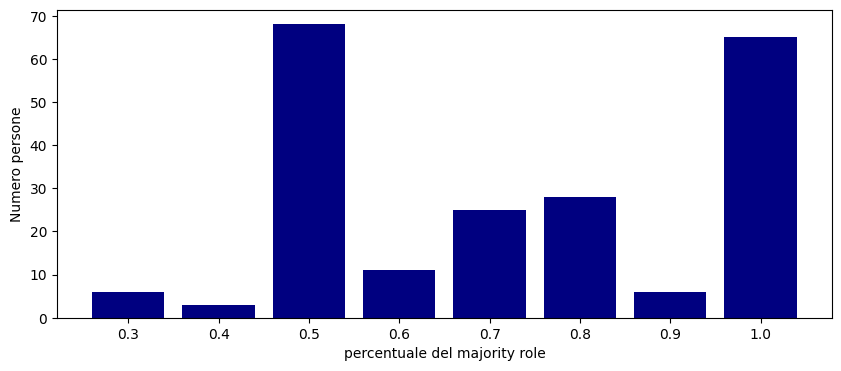

In [25]:
plt.figure(figsize = (10,4))
counter_roles_maj = dict(Counter([v for n,v in roles_for_nodes_percmajority.items() if B.degree(n)>1 ]))
for i in range(1,11):
    if i/10 in counter_roles_maj.keys():
        plt.bar(i, counter_roles_maj[i/10], color = 'navy')
        
plt.xticks([i for i in range(1,11) if i/10 in counter_roles_maj.keys()],
           [i/10 for i in range(1,11) if i/10 in counter_roles_maj.keys()])
plt.xlabel('percentuale del majority role')
plt.ylabel('Numero persone')
plt.show()

## FASE 3: ANALISI PROJECTED

* qual è la densità del grafo?
* il grafo è connesso?
* assegnando come ruole ad ogni nodo quello che assume più frequentemente, che ruole hanna maggiormente i 100 top nodi per degree centrality?


In [26]:
Bproj = bipartite.weighted_projected_graph(B, people)

In [27]:
nx.set_node_attributes(Bproj, {n:roles_for_nodes_majority[n] for n in Bproj}, 'role')

In [28]:
#Bproj.nodes(data = True)

In [29]:
nx.write_gexf(Bproj, 'projected_users_roles.gexf')

In [30]:
print(Bproj)

Graph with 829 nodes and 2253 edges


In [31]:
nx.density(Bproj)

0.0065645705494659186

In [32]:
nx.is_connected(Bproj)

False

In [33]:
len(list(nx.connected_components(Bproj)))

20

In [34]:
#d = [(n,c) for n,c in nx.degree_centrality(Bproj).items()]
d = []
for n,c in nx.degree_centrality(Bproj).items():
    d.append((n,c))
max_degree = sorted(d, key = lambda x:x[1], reverse = True)[:100]

In [35]:
roles_top100 = []
for n,c in max_degree:
    roles_top100.append(roles_for_nodes_majority[n])
Counter(roles_top100)

Counter({'Suspect': 50, 'Victim': 41, 'Witness': 9})

In [36]:
Counter([roles_for_nodes_majority[n] for n,c in max_degree])

Counter({'Suspect': 50, 'Victim': 41, 'Witness': 9})

## FASE 4: ASSORTATIVITY
* (sul grafo proiettato) i nodi con lo stesso 'role' tendono a connettersi di più tra di loro? POCHISSIMO
* (sul grafo proiettato) i nodi con alto degree tendono a connettersi con nodi ad alto degree? POCHISSIMO

In [37]:
nx.attribute_assortativity_coefficient(Bproj, 'role')

0.18638009648071435

In [38]:
nx.degree_assortativity_coefficient(Bproj)

0.14880029587966767

## FASE 5: COMMUNITY
* trova le community con l'algoritmo di Louvain
* crea un plot che mostra la distribuzione dei nodi nelle community
* Calcola coverage e performance della partizione trovata
* assegna l'attributo "community" al grafo e salvalo in .gexf


In [39]:
#! pip install python_louvain

In [40]:
from community import community_louvain

In [41]:
partition_louvain = community_louvain.best_partition(Bproj)

In [42]:
comms = defaultdict(set)
for n,c in partition_louvain.items():
    comms[c].add(n)

In [43]:
comm_len = []
for c,nodes in comms.items():
    comm_len.append((c, len(nodes)))
#comm_len = [(c, len(nodes)) for c,nodes in comms.items()]
comm_len.sort(key = lambda x: x[1],reverse = True)

In [44]:
comm_len[:4]

[(2, 57), (9, 56), (3, 52), (1, 51)]

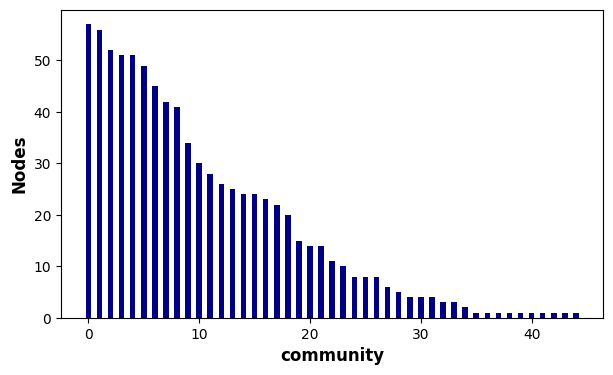

In [45]:
plt.figure(figsize = (7,4))
plt.bar(range(len(comm_len)), [x[1] for x in comm_len],width = 0.5, color = 'navy')
plt.xlabel('community',size = 12, weight = 'bold')
plt.ylabel('Nodes',size = 12, weight = 'bold')
plt.show()

In [46]:
cov, perf = nx.algorithms.community.partition_quality(Bproj, comms.values())
cov, perf  

(0.9414114513981359, 0.9632407358845708)

In [47]:
nx.set_node_attributes(Bproj, partition_louvain, 'community')

In [48]:
nx.write_gexf(Bproj, "Bproj_withcomm.gexf")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f42b5eda-db29-4143-a06b-c175ac508ba9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>